In [212]:
import tools
import pandas as pd 
import numpy as np 
import os
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt

In [213]:
def calculate_xy_mean(df, sport, color):
    print(f'    Calculating XY mean: {sport.capitalize()} | Team: {color.capitalize()}')
    df = df.dropna().copy()
    ids = tools.get_team_list(sport, color)
    cols_x = [f"{pid}_x" for pid in ids]
    cols_y = [f"{pid}_y" for pid in ids]

    df_x = df[cols_x].copy()
    df_x['mean_x'] = df_x.mean(axis=1)

    df_y = df[cols_y].copy()
    df_y['mean_y'] = df_y.mean(axis=1)

    df = pd.concat([df_x, df_y], axis=1)
    df = df[sorted(df.columns)].reset_index(drop=True)
    return df

In [214]:
def compute_strechindex(df):
    print('         Calculating Strech Index')
    df = df.copy()

    # Seleciona colunas de posição dos atletas
    x_cols = [col for col in df.columns if col.endswith('_x') and not col.startswith('mean')]
    y_cols = [col for col in df.columns if col.endswith('_y') and not col.startswith('mean')]

    # Identifica os pids (prefixos)
    pids = [col.split('_')[0] for col in x_cols]

    # Calcula ponto médio do time
    df['mean_x'] = df[x_cols].mean(axis=1)
    df['mean_y'] = df[y_cols].mean(axis=1)

    # Inicializa lista para distâncias individuais
    dist_all = []

    # Calcula distância euclidiana de cada jogador ao centro
    for pid in pids:
        dx = df[f'{pid}_x'] - df['mean_x']
        dy = df[f'{pid}_y'] - df['mean_y']
        dist = np.sqrt(dx**2 + dy**2)
        df[f'si_{pid}'] = dist
        dist_all.append(dist)

    # Calcula distância média ao centro
    dist_matrix = np.vstack(dist_all).T
    df['si_mean'] = dist_matrix.mean(axis=1)
    return df

In [215]:
def create_strechindex_video(df_b, df_o, sport, save=True):
    print(f'    Creating Centroid Distance Video | {sport.capitalize()}')

    # Obtem IDs e colunas
    blue_ids = tools.get_team_list(sport, 'blue')
    orange_ids = tools.get_team_list(sport, 'orange')
    blue_x_cols = [f'{pid}_x' for pid in blue_ids]
    blue_y_cols = [f'{pid}_y' for pid in blue_ids]
    orange_x_cols = [f'{pid}_x' for pid in orange_ids]
    orange_y_cols = [f'{pid}_y' for pid in orange_ids]

    # Cria campo
    fig, ax = tools.draw_field_court(sport)
    scat_blue = ax.scatter([], [], s=50, color='blue')
    scat_orange = ax.scatter([], [], s=50, color='orange')
    centroid_blue, = ax.plot([], [], '^', color='blue', markersize=10)
    centroid_orange, = ax.plot([], [], '^', color='orange', markersize=10)

    # Linhas de cada atleta para o centróide
    lines_blue = [ax.plot([], [], linestyle=':', color='blue')[0] for _ in blue_ids]
    lines_orange = [ax.plot([], [], linestyle=':', color='orange')[0] for _ in orange_ids]

    # Textos
    text_blue = ax.text(0.03, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')
    text_orange = ax.text(0.53, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')

    def update(frame):
        # Blue team
        blue_coords = list(zip(df_b.loc[frame, blue_x_cols], df_b.loc[frame, blue_y_cols]))
        mean_x_b = df_b.loc[frame, 'mean_x']
        mean_y_b = df_b.loc[frame, 'mean_y']
        scat_blue.set_offsets(blue_coords)
        centroid_blue.set_data([mean_x_b], [mean_y_b])
        for i, (x, y) in enumerate(blue_coords):
            lines_blue[i].set_data([x, mean_x_b], [y, mean_y_b])

        # Orange team
        orange_coords = list(zip(df_o.loc[frame, orange_x_cols], df_o.loc[frame, orange_y_cols]))
        mean_x_o = df_o.loc[frame, 'mean_x']
        mean_y_o = df_o.loc[frame, 'mean_y']
        scat_orange.set_offsets(orange_coords)
        centroid_orange.set_data([mean_x_o], [mean_y_o])
        for i, (x, y) in enumerate(orange_coords):
            lines_orange[i].set_data([x, mean_x_o], [y, mean_y_o])

        # Texto com distância média
        dist_b = df_b.loc[frame, 'si_mean']
        dist_o = df_o.loc[frame, 'si_mean']
        text_blue.set_text(f'Blue | Dist. Média: {dist_b:.2f} m')
        text_orange.set_text(f'Orange | Dist. Média: {dist_o:.2f} m')

        return (
            scat_blue, scat_orange,
            centroid_blue, centroid_orange,
            text_blue, text_orange,
            *lines_blue, *lines_orange
        )

    min_frames = min(len(df_b), len(df_o))
    anim = FuncAnimation(fig, update, frames=range(0, min_frames, 2), interval=40, blit=True)
    writer = FFMpegWriter(fps=30)

    if save:
        folder_dir = f'results/strechindex/{sport}/'
        os.makedirs(folder_dir, exist_ok=True)
        print(f'        Saving video: {folder_dir}{sport}.mp4')
        anim.save(f'{folder_dir}{sport}.mp4', writer=writer)

    return anim

In [216]:
def calculate_strechindex(sport, variable='strechindex', save=True):
    df_b, df_o = tools.load_data(sport)
    df_b = calculate_xy_mean(df_b, sport, 'blue')
    df_b = compute_strechindex(df_b)

    df_o = calculate_xy_mean(df_o, sport, 'orange')
    df_o = compute_strechindex(df_o)

    anim = create_strechindex_video(df_b, df_o, sport, save=True)

    if save == True:
        folder_dir = f'results/{variable}/{sport}/'
        print(f'        Saving data: {folder_dir}{sport}_blue.csv')
        df_b.to_csv(f'{folder_dir}{sport}_blue.csv',index=False)
        print(f'        Saving data: {folder_dir}{sport}_orange.csv')
        df_o.to_csv(f'{folder_dir}{sport}_orange.csv',index=False)
    return df_b, df_o, anim


Loading XY data: Basketball
    Calculating XY mean: Basketball | Team: Blue
         Calculating Strech Index
    Calculating XY mean: Basketball | Team: Orange
         Calculating Strech Index
    Creating Centroid Distance Video | Basketball
        Saving video: results/strechindex/basketball/basketball.mp4
        Saving data: results/strechindex/basketball/basketball_blue.csv
        Saving data: results/strechindex/basketball/basketball_orange.csv


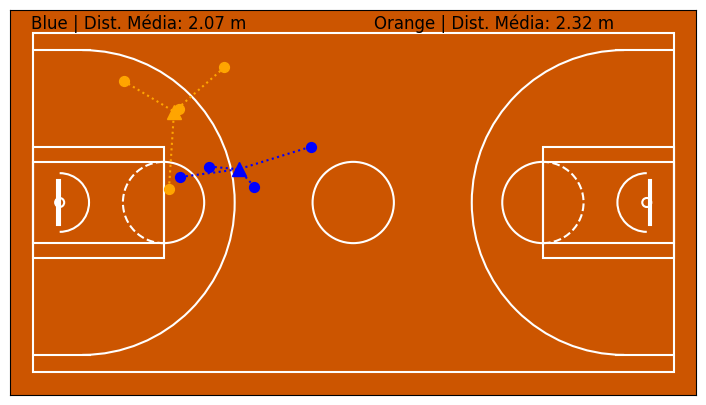

In [217]:
sport = 'basketball' #soccer, basketball, volleyball
df_b, df_o, anim = calculate_strechindex(sport)

In [ ]:
# Create video on .ipynb
HTML(anim.to_html5_video()) 